#### Load required libraries

In [1]:
import os
import numpy as np
from pyviscous import pyviscous as vs
from pyviscous import plot as vsplt

#### Load Sobol' function
The Sobol' function is defined as:
$$ Y = \prod_{i=1}^{n} \frac{|4X_i-2|+a_i}{1+a_i} $$
Set $ n=10 $, then $ X_1,…,X_{10} $ are the ten input variables uniformly distributed in $[0,1]$.<br>
We can conveniently get all the three types of function by changing $ a_i$ ([Kucherenko et al., 2011](https://www.sciencedirect.com/science/article/abs/pii/S0951832010002437)).

| Function type   | Function name   | $a_i$ value                                       |
|:----------------|:----------------|:-----------------------------------------------   |
| Type A          | A1              | $ a_i = 25$\|sin(0.5$i$) + cos(0.75$i$+2)\|$ $            |
| Type A          | A2              | $ a_1 = a_2 = 0, a_3 = $...$ = a_d = 6.25 $         |
| Type B          | B               | $ a_i = 6.25 $ |
| Type C          | C               | $ a_i = 0 $ |

In [2]:
def Sobol_function(x, a):
    ''' Sobol function
    -------
    x: input array, shape (nSample,nVar).
    a: input array, shape (nSample,nVar).
    y: output array, shape (nSample,1).'''
    
    subPart = np.abs(4*x-2)
    y = np.prod((subPart+a)/(1+a), axis=1) 

    if len(np.shape(y)) == 1: # if shape(nSample,) -> (nSample,1)
        y = y.reshape(-1,1) 

    return y

#### Configurations

In [3]:
rootPath  = '.'  # root path where example data will be stored.
outputDir = os.path.join(rootPath,'functionB')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

nVar            = 10     # number of input x variables
paramLowerLimit = 0      # lower limit of x
paramUpperLimit = 1      # upper limit of x
nSample         = 10000  # number of input data samples

sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar))

# The evaluated input variable index, starting from zero.
xIndex          = 0     # An integer.
                        # Index 0 refers to the 1st input variable x1, meaning that we aim to calculate the sensitivity index of x1.                     
                        # When compute the sensitivity indices for multiple variables, please use a loop.

#### 1. Generate input-output data

In [4]:
# Specify sample file.
if os.path.exists(sampleFile): # If exist, remove samples.
    os.remove(sampleFile)

# Generate input variable samples (x) 
x = np.zeros((nSample,nVar))
a = np.zeros((nSample,nVar))
a[:, :] = 6.52              # function B
for iVar in range(nVar):
    prng = np.random.RandomState(iVar)
    x[:,iVar] = prng.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding responses (y).
y = Sobol_function(x, a)

# Save sample data.
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Input-output data saved: %s'%(sampleFile))

Input-output data saved: ./functionB/samples_nVar10.txt


#### 2. Plot input-output, normalized, and CDF data (just for visualization)
- When we compute the first-order sensitivity index of $x_1$ for the Rosenbrock function, two variables $(x_1,y)$ need included in the VISCOUS framework. 
- Through data preparation, three sets of data are obtained: input-output data $(x_1,y)$, normalized data $(x'_{1},y')$, and marginal CDF data $(u_{x_1},u_y)$.

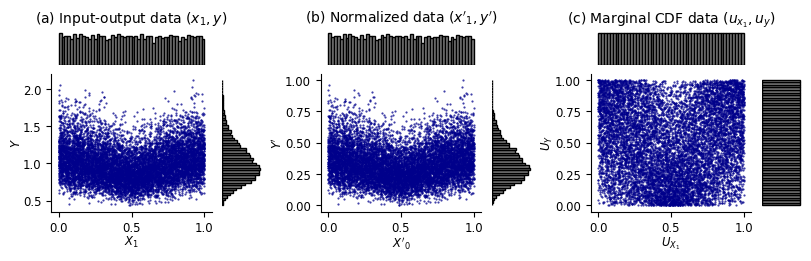

In [6]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

ofile = os.path.join(outputDir,'data.png')
vsplt.plot_data_conversion(x,y,xIndex,ofile)

#### 3. Calculate the first-order sensitivity index

##### 3.1 Calculate sensitivity index
Calculate the Sobol' first-order sensitivity index using an optimal number of Gaussian components.

In [5]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Calculate sensitivity indices using VISCOUS
# sensType has two options: 'first' or 'total'
# n_components has two options: 'optimal' or an integer. 
sens_indx_first, gmcm_first = vs.viscous(x, y, xIndex, sensType='first', n_components='optimal')  

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
    n_component = 2
	initial 1: fitting completes with convergency.
    n_component = 3
	initial 1: fitting completes with convergency.
    n_component = 4
	initial 1: fitting completes with convergency.
    n_component = 5
	initial 1: fitting completes with convergency.
    n_component = 6
	initial 1: fitting completes with convergency.
    n_component = 7
	initial 1: fitting completes with convergency.
    n_component = 8
	initial 1: fitting completes with convergency.
    n_component = 9
	initial 1: fitting completes with convergency.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  3
    Sensitivity index = 0.098778


##### 3.2 Check the estimated GMCM parameter values
- Mean and covariance are multivariate due to the multi-Gaussian-mixture nature of GMM. 
- Covariance is positive means that two random variables tend to vary in the same direction. Covariance is positive means that they vary in opposite directions. Covariance zero means that they don't vary together. 

In [6]:
gmm                = gmcm_first
gmmNComponents     = gmm.params.n_clusters    # number of components
gmmWeights         = gmm.params.prob          # shape (n_components,)
gmmMeans           = gmm.params.means         # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances     = gmm.params.covs          # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    

print(gmmNComponents)

3


##### Plot the means and covariances of GMM components

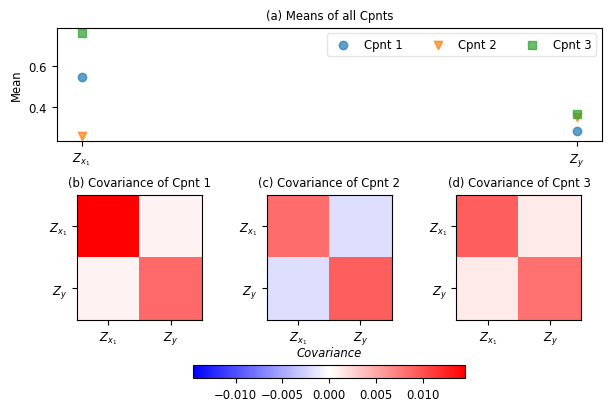

In [7]:
sensType='first'                                                 # Sensitivity type
ofile = os.path.join(outputDir,'gmm_parameters_first_order.png') # Output figure file
vsplt.plot_gmm_mean_cov(gmcm_first, sensType, xIndex, ofile)     # Plot

##### 3.3 Plot the inverse CDF data, their PDFs and clusters in GMM.
- $(z_{x_1},z_y)$ are the inverse CDFs of $(u_{x_1},u_y)$ in the fitted GMCM.<br>
- Plot the histogram (panel a), GMM PDF (panel b), and GMM clustering (panel c) results for $(z_{x_1},z_y)$.

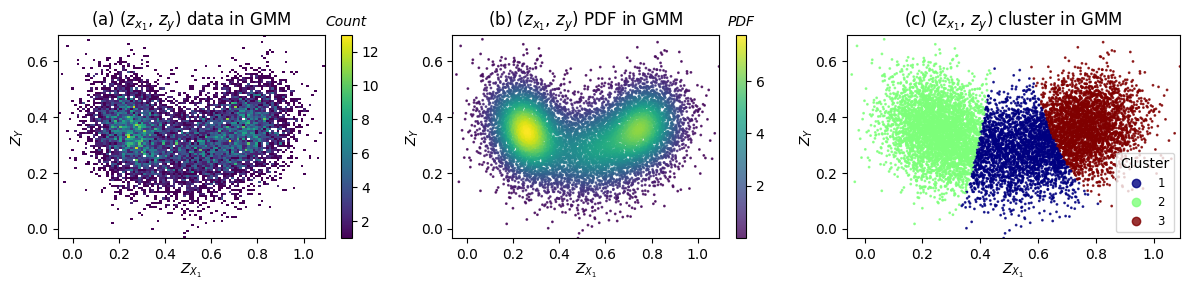

In [9]:
ofile   = os.path.join(outputDir,'gmm_components_first_order.png') # Output figure file
vsplt.plot_gmm_pdf_cluster(gmcm_first, x, y, xIndex, ofile)        # Plot

#### 4. Calculate the total-order sensitivity index

##### 4.1 Calculate sensitivity index
Calculate the Sobol' total-order sensitivity index using an optimal number of Gaussian components.

In [12]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Calculate sensitivity indices using VISCOUS
# sensType argument has two options: 'first' or 'total' 
sens_indx_total, gmcm_total = vs.viscous(x, y, xIndex, sensType='total', n_components='optimal')  

Calculating total-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
    n_component = 2
	initial 1: fitting completes with convergency.
    n_component = 3
	initial 1: fitting completes with convergency.
    n_component = 4
	initial 1: fitting completes with convergency.
    n_component = 5
	initial 1: fitting completes with convergency.
    n_component = 6


/Users/hongliliu/venvs/test_pvs/lib/python3.9/site-packages/copulae/mixtures/gmc/estimators/em.py:68: UserWarning: Max iterations reached
  warn('Max iterations reached')


	initial 2: fitting completes with convergency.
    n_component = 7
	initial 1: fitting completes with convergency.
    n_component = 8
	initial 1: fitting completes with convergency.
    n_component = 9
	initial 1: fitting completes with convergency.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  8
    Sensitivity index = 0.688324


##### 4.2 Check the estimated GMCM parameter values

In [13]:
gmm                = gmcm_total
gmmNComponents     = gmm.params.n_clusters    # number of components
gmmWeights         = gmm.params.prob          # shape (n_components,)
gmmMeans           = gmm.params.means         # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances     = gmm.params.covs          # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    

print(gmmNComponents)

##### Plot the means and covariances of GMM components

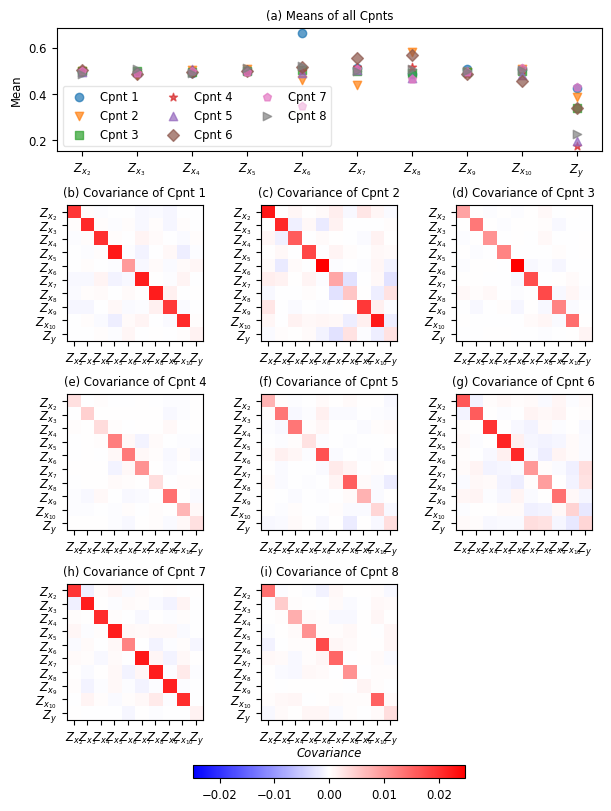

In [15]:
sensType = 'total'                                                 # Sensitivity type
ofile = os.path.join(outputDir,'gmm_parameters_total_order.png')   # Output figure file
vsplt.plot_gmm_mean_cov(gmcm_total, sensType, xIndex, ofile)       # Plot